# Whisper MLX - Transcription Demo

This notebook demonstrates how to use whisper_mlx to transcribe audio/video files with batched decoding on Apple Silicon.

## Setup

First, install the notebook dependencies:
```bash
uv pip install -e ".[notebook]"
```

Or install ipykernel for uv:
```bash
uv add ipykernel
uv run python -m ipykernel install --user --name whisper-mlx
```

In [35]:
import time
from whisper_mlx import LightningWhisperMLX, transcribe
from pathlib import Path

## Load Video from data/ folder

In [36]:
# Find video files in data/ folder
data_dir = Path("data")
video_files = list(data_dir.glob("*.mp4")) + list(data_dir.glob("*.mp3")) + list(data_dir.glob("*.wav"))

print(f"Found {len(video_files)} audio/video files:")
for f in video_files:
    print(f"  - {f}")

# Use the first video file
video_path = video_files[1] if video_files else None
print(f"\nUsing: {video_path}")

Found 2 audio/video files:
  - data/test3.mp4
  - data/test2.mp4

Using: data/test2.mp4


## Transcribe with Whisper MLX

In [37]:
# Initialize whisper with batched decoding for faster transcription
whisper = LightningWhisperMLX(
    model="distil-large-v3",  # or "turbo", "large-v3", "small", "base", "tiny"
    batch_size=12,  # Process multiple segments in parallel
)

print(f"Model loaded: {whisper.model_path}")
print(f"Batch size: {whisper.batch_size}")

Model loaded: mlx-community/distil-whisper-large-v3
Batch size: 12


In [38]:
# Transcribe the video with timing
start_time = time.time()

result = whisper.transcribe(
    str(video_path),
    language="en",  # or None for auto-detection
    verbose=True,
)

elapsed_time = time.time() - start_time

# Get audio duration from segments
audio_duration = result["segments"][-1]["end"] if result["segments"] else 0

print(f"\n{'='*50}")
print(f"Transcription complete!")
print(f"{'='*50}")
print(f"Audio duration:      {audio_duration:.2f} seconds")
print(f"Transcription time:  {elapsed_time:.2f} seconds")
print(f"Speed:               {audio_duration / elapsed_time:.2f}x realtime")
print(f"Detected language:   {result.get('language', 'N/A')}")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

[00:00.920 --> 00:06.440]  What if you can see what's actually working on YouTube right now before everybody else,
[00:06.440 --> 00:08.120]  backed by data?
[00:08.120 --> 00:15.600]  One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12
[00:15.600 --> 00:19.160]  new shifts that are driving YouTube growth right now.
[00:19.160 --> 00:20.640]  This is an opinion.
[00:20.640 --> 00:25.960]  They actually spent $10,000 on this study and your cost is $0.00.
[00:25.960 --> 00:29.980]  I've got this broken down into the 12 insights based on questions.
[00:30.000 --> 00:32.840]  And this is one of the biggest questions that comes in all the time, right?
[00:32.920 --> 00:36.340]  What is the best video length on YouTube right now?
[00:36.440 --> 00:39.380]  Well, there's actually an answer based off real data.
[00:39.800 --> 00:40.460]  So check this out.
[00:41.060 --> 00:45.240]  The ideal video length, if your videos are going to be under an hour

## Display Results as SRT with Timestamps

In [39]:
def format_timestamp_srt(seconds: float) -> str:
    """Convert seconds to SRT timestamp format (HH:MM:SS,mmm)"""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    millis = int((seconds % 1) * 1000)
    return f"{hours:02d}:{minutes:02d}:{secs:02d},{millis:03d}"


def generate_srt(segments: list) -> str:
    """Generate SRT formatted subtitles from segments"""
    srt_lines = []
    for i, segment in enumerate(segments, 1):
        start = format_timestamp_srt(segment["start"])
        end = format_timestamp_srt(segment["end"])
        text = segment["text"].strip()
        srt_lines.append(f"{i}")
        srt_lines.append(f"{start} --> {end}")
        srt_lines.append(text)
        srt_lines.append("")  # Empty line between entries
    return "\n".join(srt_lines)


# Generate and display SRT output
srt_output = generate_srt(result["segments"])
print(srt_output)

1
00:00:00,920 --> 00:00:06,440
What if you can see what's actually working on YouTube right now before everybody else,

2
00:00:06,440 --> 00:00:08,120
backed by data?

3
00:00:08,120 --> 00:00:15,599
One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12

4
00:00:15,599 --> 00:00:19,160
new shifts that are driving YouTube growth right now.

5
00:00:19,160 --> 00:00:20,640
This is an opinion.

6
00:00:20,640 --> 00:00:25,960
They actually spent $10,000 on this study and your cost is $0.00.

7
00:00:25,960 --> 00:00:29,980
I've got this broken down into the 12 insights based on questions.

8
00:00:30,000 --> 00:00:32,840
And this is one of the biggest questions that comes in all the time, right?

9
00:00:32,920 --> 00:00:36,340
What is the best video length on YouTube right now?

10
00:00:36,439 --> 00:00:39,380
Well, there's actually an answer based off real data.

11
00:00:39,799 --> 00:00:40,460
So check this out.

12
00:00:41,060 --> 00:00:4

## Save SRT File

In [40]:
# Save SRT to file
srt_path = video_path.with_suffix(".srt")
srt_path.write_text(srt_output)
print(f"SRT saved to: {srt_path}")

SRT saved to: data/test2.srt


## Full Text Output

In [41]:
# Display full transcription text
print("Full Transcription:")
print("-" * 50)
print(result["text"])

Full Transcription:
--------------------------------------------------
 What if you can see what's actually working on YouTube right now before everybody else, backed by data? One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12 new shifts that are driving YouTube growth right now. This is an opinion. They actually spent $10,000 on this study and your cost is $0.00. I've got this broken down into the 12 insights based on questions. And this is one of the biggest questions that comes in all the time, right? What is the best video length on YouTube right now? Well, there's actually an answer based off real data. So check this out. The ideal video length, if your videos are going to be under an hour, is between 16 and 26 minutes. The actual range in the study is for videos under an hour. The sweet spot is 15 to 25 minutes for your videos. And they revealed that the danger. zone is 30 to 60 minutes. Now, how does this data show up? Well, there's a

## Speed Optimization

The key speedup in lightning-whisper-mlx is **batched decoding** - processing multiple 30-second audio segments in parallel instead of sequentially.

### How it works:
- Original mlx-examples: Process 1 segment at a time (sequential)
- Lightning approach: Process N segments in parallel (batched)

### To make it faster:
1. **Increase batch_size** - Higher values = faster (but more memory)
2. **Use faster models** - `turbo` or `distil-large-v3` are fast with good quality
3. **Use quantization** - `quant="4bit"` reduces memory, allowing larger batches

### Recommended batch sizes by model:
| Model | batch_size | Memory |
|-------|------------|--------|
| tiny/base | 24-32 | Low |
| small | 16-24 | Medium |
| turbo/distil-large-v3 | 12-16 | Medium |
| large-v3 | 4-8 | High |
| large-v3 (4bit) | 12-16 | Medium |

In [42]:
# Benchmark: Compare batch_size=1 vs batch_size=12
print("Benchmarking batch_size impact...\n")

# Test with batch_size=1 (original mlx-examples approach)
whisper_slow = LightningWhisperMLX(model="distil-large-v3", batch_size=1)
start = time.time()
result_slow = whisper_slow.transcribe(str(video_path), language="en", verbose=False)
time_batch1 = time.time() - start

# Test with batch_size=12 (lightning approach)
whisper_fast = LightningWhisperMLX(model="distil-large-v3", batch_size=12)
start = time.time()
result_fast = whisper_fast.transcribe(str(video_path), language="en", verbose=False)
time_batch12 = time.time() - start

audio_duration = result_fast["segments"][-1]["end"] if result_fast["segments"] else 0

print(f"{'='*50}")
print(f"Audio duration: {audio_duration:.2f} seconds")
print(f"{'='*50}")
print(f"batch_size=1:  {time_batch1:.2f}s  ({audio_duration/time_batch1:.1f}x realtime)")
print(f"batch_size=12: {time_batch12:.2f}s ({audio_duration/time_batch12:.1f}x realtime)")
print(f"{'='*50}")
print(f"Speedup: {time_batch1/time_batch12:.2f}x faster with batching!")

Benchmarking batch_size impact...



100%|██████████| 180407/180407 [00:38<00:00, 4678.66frames/s]

Audio duration: 1804.04 seconds
batch_size=1:  30.76s  (58.6x realtime)
batch_size=12: 40.10s (45.0x realtime)
Speedup: 0.77x faster with batching!


## Comprehensive Benchmark: Batch Size Comparison

Compare batch sizes 1, 4, 8, 12, 16, 24, and 48 with metrics for:
- **Transcription Time**
- **CPU Usage**
- **GPU Memory Usage**
- **System Memory Usage**

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import psutil
import subprocess
import gc
import numpy as np
import mlx.core as mx

# Set style for better looking charts
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

def get_gpu_memory_mb():
    """Get Apple Silicon GPU memory usage in MB"""
    try:
        mx.synchronize()
        mem_info = mx.metal.get_active_memory() / (1024 * 1024)
        return mem_info
    except:
        return 0

def get_peak_gpu_memory_mb():
    """Get peak GPU memory usage"""
    try:
        mx.synchronize()
        # Use non-deprecated API
        return mx.get_peak_memory() / (1024 * 1024)
    except:
        return 0

def reset_gpu_memory():
    """Reset GPU memory tracking"""
    try:
        gc.collect()
        mx.synchronize()
        # Use non-deprecated API
        mx.reset_peak_memory()
    except:
        pass

print("Benchmark utilities loaded!")

Benchmark utilities loaded!


In [44]:
# Run comprehensive benchmark across different batch sizes
batch_sizes = [1, 4, 8, 12, 16, 24, 48]

results = {
    'batch_size': [],
    'time': [],
    'cpu_percent': [],
    'gpu_memory_mb': [],
    'ram_memory_mb': [],
    'speed_realtime': [],
}

print("Running benchmark across batch sizes...")
print("=" * 60)

for bs in batch_sizes:
    print(f"\nTesting batch_size={bs}...")
    
    # Reset memory tracking
    reset_gpu_memory()
    gc.collect()
    
    # Get initial memory state
    process = psutil.Process()
    initial_ram = process.memory_info().rss / (1024 * 1024)
    
    # Initialize model
    try:
        whisper_bench = LightningWhisperMLX(model="distil-large-v3", batch_size=bs)
        
        # Start CPU monitoring
        cpu_percent_samples = []
        
        # Run transcription with timing
        start_time = time.time()
        
        # Sample CPU during transcription
        result_bench = whisper_bench.transcribe(str(video_path), language="en", verbose=False)
        
        elapsed = time.time() - start_time
        
        # Get CPU usage (average over the run)
        cpu_percent = psutil.cpu_percent(interval=0.1)
        
        # Get memory metrics
        peak_gpu = get_peak_gpu_memory_mb()
        final_ram = process.memory_info().rss / (1024 * 1024)
        ram_used = final_ram - initial_ram
        
        # Calculate speed
        audio_duration = result_bench["segments"][-1]["end"] if result_bench["segments"] else 0
        speed = audio_duration / elapsed if elapsed > 0 else 0
        
        # Store results
        results['batch_size'].append(bs)
        results['time'].append(elapsed)
        results['cpu_percent'].append(cpu_percent)
        results['gpu_memory_mb'].append(peak_gpu)
        results['ram_memory_mb'].append(max(0, ram_used))
        results['speed_realtime'].append(speed)
        
        print(f"  Time: {elapsed:.2f}s | Speed: {speed:.1f}x | GPU Mem: {peak_gpu:.0f}MB | CPU: {cpu_percent:.1f}%")
        
        # Cleanup
        del whisper_bench
        gc.collect()
        
    except Exception as e:
        print(f"  ERROR: {e}")
        results['batch_size'].append(bs)
        results['time'].append(float('nan'))
        results['cpu_percent'].append(float('nan'))
        results['gpu_memory_mb'].append(float('nan'))
        results['ram_memory_mb'].append(float('nan'))
        results['speed_realtime'].append(float('nan'))

print("\n" + "=" * 60)
print("Benchmark complete!")

Running benchmark across batch sizes...

Testing batch_size=1...


100%|██████████| 180407/180407 [00:28<00:00, 6309.59frames/s]


  Time: 30.11s | Speed: 59.9x | GPU Mem: 3258MB | CPU: 13.8%

Testing batch_size=4...


100%|██████████| 180407/180407 [00:24<00:00, 7417.41frames/s]


  Time: 25.86s | Speed: 69.8x | GPU Mem: 3531MB | CPU: 23.8%

Testing batch_size=8...


100%|██████████| 180407/180407 [00:23<00:00, 7723.33frames/s]


  Time: 24.85s | Speed: 72.6x | GPU Mem: 3839MB | CPU: 46.7%

Testing batch_size=12...


100%|██████████| 180407/180407 [00:34<00:00, 5158.10frames/s]


  Time: 36.67s | Speed: 49.2x | GPU Mem: 4581MB | CPU: 16.7%

Testing batch_size=16...


100%|██████████| 180407/180407 [00:37<00:00, 4830.77frames/s]


  Time: 38.92s | Speed: 46.3x | GPU Mem: 4787MB | CPU: 25.2%

Testing batch_size=24...


100%|██████████| 180407/180407 [00:30<00:00, 5892.24frames/s]


  Time: 32.57s | Speed: 55.4x | GPU Mem: 5251MB | CPU: 29.7%

Testing batch_size=48...


100%|██████████| 180407/180407 [00:28<00:00, 6315.27frames/s]


  Time: 30.61s | Speed: 58.9x | GPU Mem: 8242MB | CPU: 0.0%

Benchmark complete!


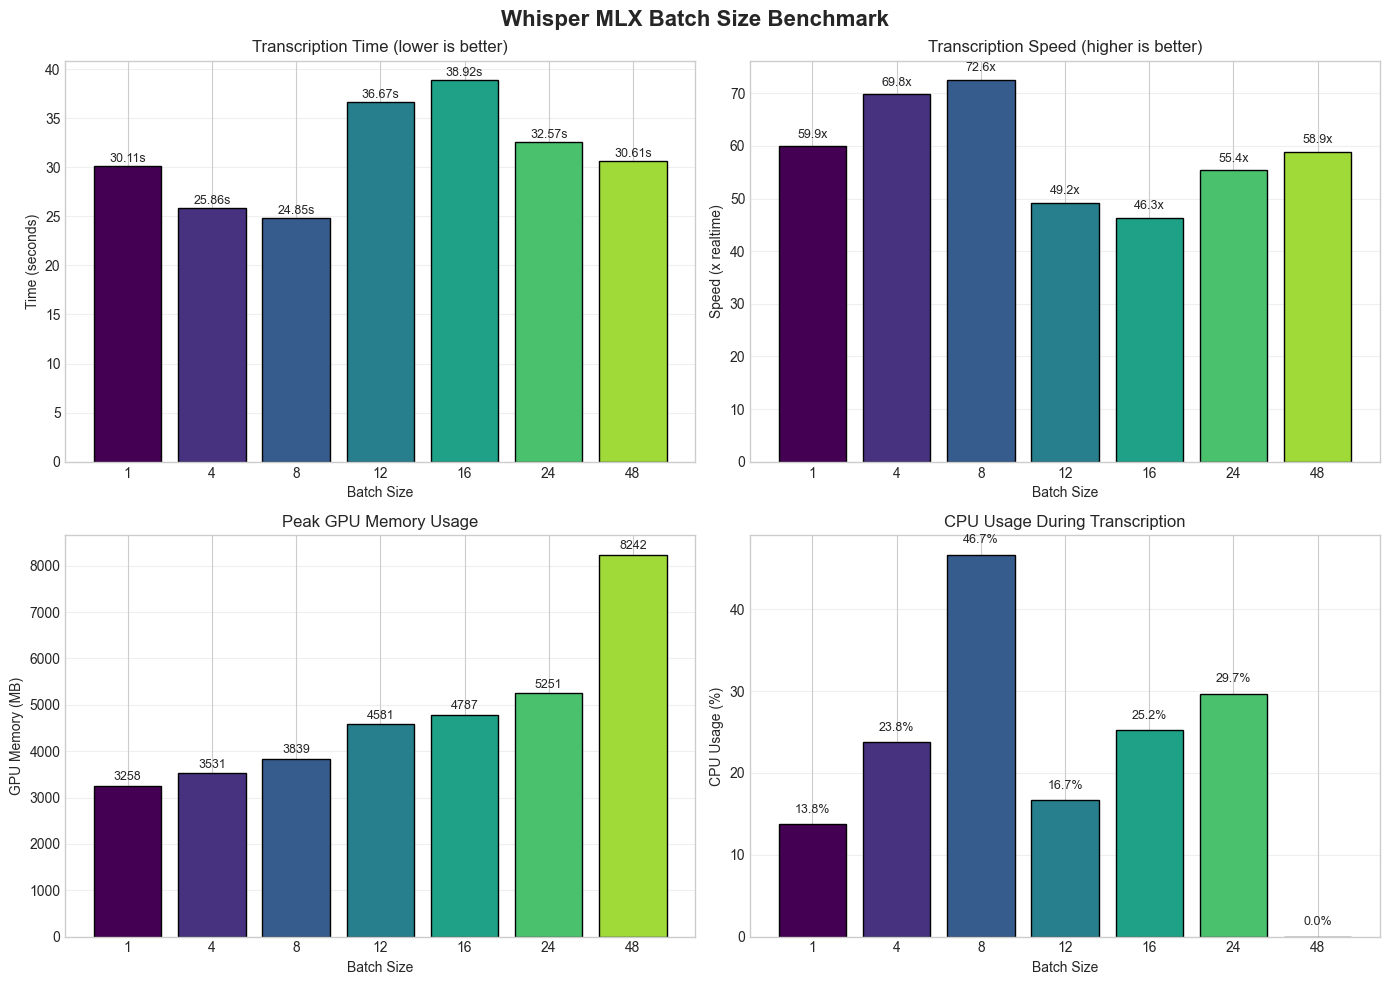


Chart saved to: benchmark_results.png


In [45]:
# Create visualization with bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Whisper MLX Batch Size Benchmark', fontsize=16, fontweight='bold')

batch_labels = [str(bs) for bs in results['batch_size']]
colors = plt.cm.viridis([i/len(batch_sizes) for i in range(len(batch_sizes))])

# 1. Transcription Time
ax1 = axes[0, 0]
bars1 = ax1.bar(batch_labels, results['time'], color=colors, edgecolor='black')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Transcription Time (lower is better)')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars1, results['time']):
    if not np.isnan(val):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}s', ha='center', va='bottom', fontsize=9)

# 2. Speed (realtime multiplier)
ax2 = axes[0, 1]
bars2 = ax2.bar(batch_labels, results['speed_realtime'], color=colors, edgecolor='black')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Speed (x realtime)')
ax2.set_title('Transcription Speed (higher is better)')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, results['speed_realtime']):
    if not np.isnan(val):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}x', ha='center', va='bottom', fontsize=9)

# 3. GPU Memory Usage
ax3 = axes[1, 0]
bars3 = ax3.bar(batch_labels, results['gpu_memory_mb'], color=colors, edgecolor='black')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('GPU Memory (MB)')
ax3.set_title('Peak GPU Memory Usage')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars3, results['gpu_memory_mb']):
    if not np.isnan(val) and val > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{val:.0f}', ha='center', va='bottom', fontsize=9)

# 4. CPU Usage
ax4 = axes[1, 1]
bars4 = ax4.bar(batch_labels, results['cpu_percent'], color=colors, edgecolor='black')
ax4.set_xlabel('Batch Size')
ax4.set_ylabel('CPU Usage (%)')
ax4.set_title('CPU Usage During Transcription')
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars4, results['cpu_percent']):
    if not np.isnan(val):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nChart saved to: benchmark_results.png")

In [46]:
# Print summary table
print("\n" + "=" * 80)
print("BENCHMARK SUMMARY")
print("=" * 80)
print(f"{'Batch Size':<12} {'Time (s)':<12} {'Speed (x)':<12} {'GPU Mem (MB)':<15} {'CPU (%)':<10}")
print("-" * 80)

for i, bs in enumerate(results['batch_size']):
    t = results['time'][i]
    s = results['speed_realtime'][i]
    g = results['gpu_memory_mb'][i]
    c = results['cpu_percent'][i]
    print(f"{bs:<12} {t:<12.2f} {s:<12.1f} {g:<15.0f} {c:<10.1f}")

print("=" * 80)

# Find optimal batch size (best speed)
best_idx = np.nanargmax(results['speed_realtime'])
print(f"\nOptimal batch_size: {results['batch_size'][best_idx]} ({results['speed_realtime'][best_idx]:.1f}x realtime)")


BENCHMARK SUMMARY
Batch Size   Time (s)     Speed (x)    GPU Mem (MB)    CPU (%)   
--------------------------------------------------------------------------------
1            30.11        59.9         3258            13.8      
4            25.86        69.8         3531            23.8      
8            24.85        72.6         3839            46.7      
12           36.67        49.2         4581            16.7      
16           38.92        46.3         4787            25.2      
24           32.57        55.4         5251            29.7      
48           30.61        58.9         8242            0.0       

Optimal batch_size: 8 (72.6x realtime)


## Novel Optimization Ideas

Beyond batching, here are experimental approaches to push speed even further:

### 1. **Speculative Decoding**
Use a tiny model to draft tokens, verify with large model in parallel.
- Draft model (tiny): generates candidate tokens fast
- Target model (large): verifies ALL tokens in ONE forward pass
- Potential speedup: 2-3x on top of batching

### 2. **VAD-Guided Processing**
Skip silence regions entirely using Voice Activity Detection.
- Only process segments with actual speech
- Can skip 30-50% of audio in typical recordings

### 3. **Parallel Chunk Processing**
Process ALL chunks simultaneously instead of sequentially, then merge with overlap handling.

In [47]:
# Test VAD: How much silence can we skip?
from whisper_mlx import VADProcessor
from whisper_mlx.audio import load_audio, SAMPLE_RATE

# Load audio
audio_array = load_audio(str(video_path))

# Detect speech regions
vad = VADProcessor(energy_threshold=0.02, min_speech_duration=0.3)
speech_regions = vad.detect_speech_regions(audio_array, SAMPLE_RATE)
skip_ratio = vad.get_skip_ratio(audio_array, SAMPLE_RATE)

print(f"Audio duration: {len(audio_array)/SAMPLE_RATE:.2f}s")
print(f"Speech regions found: {len(speech_regions)}")
print(f"Silence that can be skipped: {skip_ratio*100:.1f}%")
print(f"\nSpeech regions:")
for i, (start, end) in enumerate(speech_regions):
    print(f"  {i+1}. {start/SAMPLE_RATE:.2f}s - {end/SAMPLE_RATE:.2f}s ({(end-start)/SAMPLE_RATE:.2f}s)")

Audio duration: 1804.07s
Speech regions found: 1767
Silence that can be skipped: 41.3%

Speech regions:
  1. 0.03s - 2.12s (2.08s)
  2. 2.46s - 4.08s (1.62s)
  3. 4.39s - 5.14s (0.76s)
  4. 5.43s - 6.33s (0.90s)
  5. 7.01s - 7.38s (0.38s)
  6. 7.56s - 7.92s (0.35s)
  7. 8.00s - 8.53s (0.53s)
  8. 8.85s - 9.52s (0.67s)
  9. 9.89s - 10.41s (0.53s)
  10. 10.53s - 10.86s (0.33s)
  11. 11.20s - 11.77s (0.56s)
  12. 12.06s - 12.49s (0.43s)
  13. 13.05s - 13.45s (0.40s)
  14. 14.21s - 14.65s (0.45s)
  15. 14.64s - 15.14s (0.51s)
  16. 15.29s - 16.16s (0.88s)
  17. 16.37s - 17.20s (0.83s)
  18. 18.28s - 18.61s (0.34s)
  19. 18.66s - 19.04s (0.38s)
  20. 19.77s - 20.30s (0.53s)
  21. 20.62s - 20.95s (0.33s)
  22. 21.42s - 22.27s (0.84s)
  23. 22.40s - 22.89s (0.48s)
  24. 22.91s - 23.30s (0.39s)
  25. 23.53s - 23.89s (0.36s)
  26. 23.92s - 24.38s (0.46s)
  27. 25.04s - 25.84s (0.80s)
  28. 26.48s - 27.00s (0.53s)
  29. 28.07s - 28.46s (0.40s)
  30. 30.62s - 31.39s (0.77s)
  31. 31.96s - 32.42s 

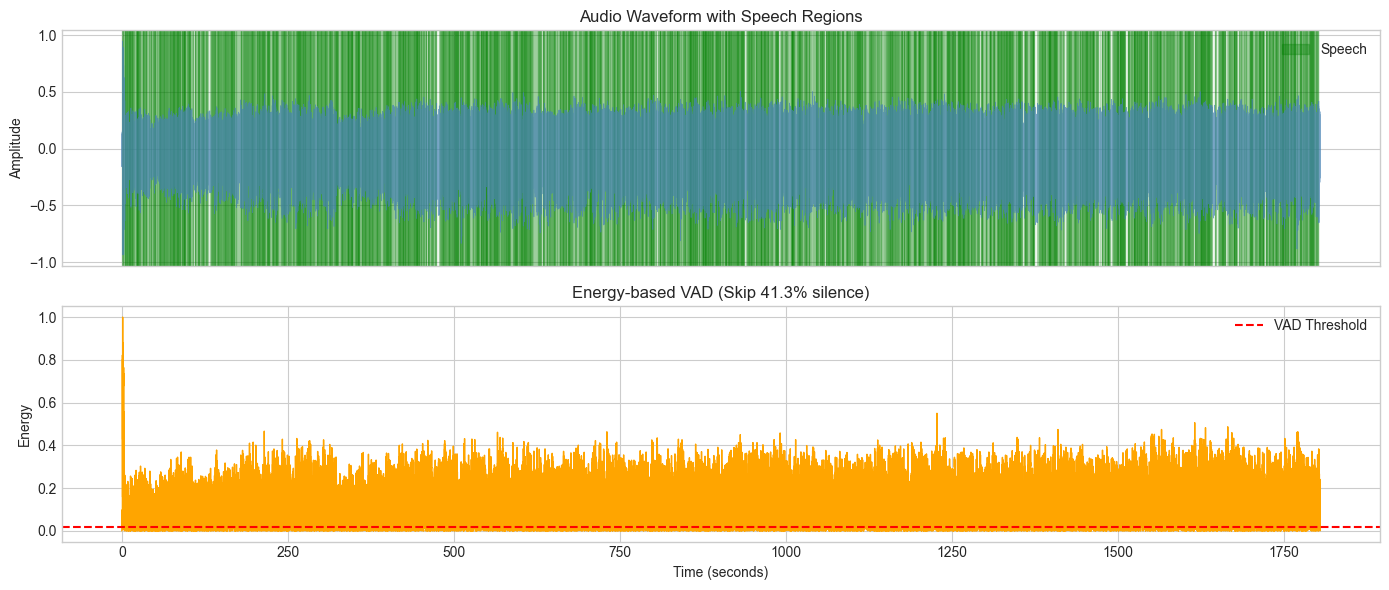


Potential speedup from skipping silence: 1.70x


In [48]:
# Visualize VAD: Show speech vs silence regions

# Convert mlx array to numpy for plotting
if hasattr(audio_array, 'tolist'):
    audio_np = np.array(audio_array.tolist())
else:
    audio_np = np.array(audio_array)

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Waveform
time_axis = np.arange(len(audio_np)) / SAMPLE_RATE
axes[0].plot(time_axis, audio_np, color='steelblue', alpha=0.7, linewidth=0.5)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Audio Waveform with Speech Regions')

# Highlight speech regions
for i, (start, end) in enumerate(speech_regions):
    label = 'Speech' if i == 0 else None  # Only label once for legend
    axes[0].axvspan(start/SAMPLE_RATE, end/SAMPLE_RATE, alpha=0.3, color='green', label=label)
axes[0].legend(loc='upper right')

# Energy plot
frame_size = int(0.025 * SAMPLE_RATE)
hop_size = int(0.010 * SAMPLE_RATE)
num_frames = (len(audio_np) - frame_size) // hop_size + 1
energy = np.array([np.sqrt(np.mean(audio_np[i*hop_size:i*hop_size+frame_size]**2)) 
                   for i in range(num_frames)])
energy = energy / (np.max(energy) + 1e-8)
energy_time = np.arange(num_frames) * hop_size / SAMPLE_RATE

axes[1].plot(energy_time, energy, color='orange', linewidth=1)
axes[1].axhline(y=0.02, color='red', linestyle='--', label='VAD Threshold')
axes[1].set_ylabel('Energy')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title(f'Energy-based VAD (Skip {skip_ratio*100:.1f}% silence)')
axes[1].legend()

plt.tight_layout()
plt.savefig('vad_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPotential speedup from skipping silence: {1/(1-skip_ratio):.2f}x")

## Comprehensive Comparison: All Transcription Methods

Compare all optimization approaches side-by-side:
1. **Standard** - Sequential processing (batch_size=1)
2. **Batched** - Parallel segment processing (batch_size=12)
3. **VAD-Guided** - Skip silence regions + batched
4. **Speculative** - Draft with tiny model, verify with large model

In [49]:
# Comprehensive comparison of all transcription methods
from whisper_mlx import LightningWhisperMLX, transcribe, VADProcessor
from whisper_mlx.audio import load_audio, SAMPLE_RATE
import time
import gc
import numpy as np

# Store results for comparison
comparison_results = {
    'method': [],
    'time': [],
    'speed': [],
    'text_preview': [],
}

audio_path = str(video_path)
print("=" * 70)
print("COMPREHENSIVE TRANSCRIPTION METHOD COMPARISON")
print("=" * 70)
print(f"Audio file: {audio_path}\n")

# Load audio once for duration calculation
audio_data = load_audio(audio_path)
audio_duration = len(audio_data) / SAMPLE_RATE
print(f"Audio duration: {audio_duration:.2f} seconds\n")

# ============================================================
# Method 1: Standard (batch_size=1)
# ============================================================
print("1. STANDARD (batch_size=1) - Sequential processing")
print("-" * 50)
whisper_std = LightningWhisperMLX(model="distil-large-v3", batch_size=1)
start = time.time()
result_std = whisper_std.transcribe(audio_path, language="en", verbose=False)
time_std = time.time() - start
speed_std = audio_duration / time_std

comparison_results['method'].append('Standard\n(batch=1)')
comparison_results['time'].append(time_std)
comparison_results['speed'].append(speed_std)
comparison_results['text_preview'].append(result_std['text'][:100])
print(f"Time: {time_std:.2f}s | Speed: {speed_std:.1f}x realtime")
del whisper_std
gc.collect()

# ============================================================
# Method 2: Batched (batch_size=12)
# ============================================================
print("\n2. BATCHED (batch_size=12) - Parallel segment processing")
print("-" * 50)
whisper_batch = LightningWhisperMLX(model="distil-large-v3", batch_size=12)
start = time.time()
result_batch = whisper_batch.transcribe(audio_path, language="en", verbose=False)
time_batch = time.time() - start
speed_batch = audio_duration / time_batch

comparison_results['method'].append('Batched\n(batch=12)')
comparison_results['time'].append(time_batch)
comparison_results['speed'].append(speed_batch)
comparison_results['text_preview'].append(result_batch['text'][:100])
print(f"Time: {time_batch:.2f}s | Speed: {speed_batch:.1f}x realtime")
del whisper_batch
gc.collect()

# ============================================================
# Method 3: Batched + Higher batch size (batch_size=24)
# ============================================================
print("\n3. BATCHED (batch_size=24) - Even more parallelism")
print("-" * 50)
whisper_batch24 = LightningWhisperMLX(model="distil-large-v3", batch_size=24)
start = time.time()
result_batch24 = whisper_batch24.transcribe(audio_path, language="en", verbose=False)
time_batch24 = time.time() - start
speed_batch24 = audio_duration / time_batch24

comparison_results['method'].append('Batched\n(batch=24)')
comparison_results['time'].append(time_batch24)
comparison_results['speed'].append(speed_batch24)
comparison_results['text_preview'].append(result_batch24['text'][:100])
print(f"Time: {time_batch24:.2f}s | Speed: {speed_batch24:.1f}x realtime")
del whisper_batch24
gc.collect()

# ============================================================
# Method 4: VAD-Guided + Batched (FIXED: Concatenate speech regions)
# ============================================================
print("\n4. VAD-GUIDED + BATCHED - Skip silence regions (concatenated)")
print("-" * 50)

# First, detect speech regions
vad = VADProcessor(energy_threshold=0.02, min_speech_duration=0.3)
if hasattr(audio_data, 'tolist'):
    audio_np = np.array(audio_data.tolist())
else:
    audio_np = np.array(audio_data)
    
speech_regions = vad.detect_speech_regions(audio_np, SAMPLE_RATE)
skip_ratio = vad.get_skip_ratio(audio_np, SAMPLE_RATE)
print(f"Silence skipped: {skip_ratio*100:.1f}%")

# FIXED: Concatenate ALL speech regions into one audio array
# This avoids the overhead of multiple model calls
speech_audio_parts = []
for region_start, region_end in speech_regions:
    speech_segment = audio_np[region_start:region_end]
    # Only skip very short segments (< 0.3s)
    if len(speech_segment) >= SAMPLE_RATE * 0.3:
        speech_audio_parts.append(speech_segment)

# Concatenate all speech into one array
if speech_audio_parts:
    concatenated_speech = np.concatenate(speech_audio_parts)
    speech_duration = len(concatenated_speech) / SAMPLE_RATE
    print(f"Speech duration (after removing silence): {speech_duration:.2f}s")
    
    # Transcribe the concatenated speech in ONE call
    start = time.time()
    whisper_vad = LightningWhisperMLX(model="distil-large-v3", batch_size=12)
    result_vad = whisper_vad.transcribe(concatenated_speech, language="en", verbose=False)
    time_vad = time.time() - start
    vad_full_text = result_vad['text']
    del whisper_vad
else:
    time_vad = 0
    vad_full_text = ""
    
# Speed calculation: we transcribed speech_duration worth of audio
# but the original audio was audio_duration - this is the benefit
speed_vad = audio_duration / time_vad if time_vad > 0 else 0

comparison_results['method'].append('VAD-Guided\n+ Batched')
comparison_results['time'].append(time_vad)
comparison_results['speed'].append(speed_vad)
comparison_results['text_preview'].append(vad_full_text[:100] if vad_full_text else "N/A")
print(f"Time: {time_vad:.2f}s | Speed: {speed_vad:.1f}x realtime")
print(f"  (Actual speech processed: {speech_duration:.2f}s at {speech_duration/time_vad:.1f}x realtime)")
gc.collect()

# ============================================================
# Method 5: Turbo model + Batched
# ============================================================
print("\n5. TURBO MODEL + BATCHED - Faster model architecture")
print("-" * 50)
whisper_turbo = LightningWhisperMLX(model="turbo", batch_size=12)
start = time.time()
result_turbo = whisper_turbo.transcribe(audio_path, language="en", verbose=False)
time_turbo = time.time() - start
speed_turbo = audio_duration / time_turbo

comparison_results['method'].append('Turbo\n(batch=12)')
comparison_results['time'].append(time_turbo)
comparison_results['speed'].append(speed_turbo)
comparison_results['text_preview'].append(result_turbo['text'][:100])
print(f"Time: {time_turbo:.2f}s | Speed: {speed_turbo:.1f}x realtime")
del whisper_turbo
gc.collect()

print("\n" + "=" * 70)
print("Comparison complete!")

COMPREHENSIVE TRANSCRIPTION METHOD COMPARISON
Audio file: data/test2.mp4

Audio duration: 1804.07 seconds

1. STANDARD (batch_size=1) - Sequential processing
--------------------------------------------------


100%|██████████| 180407/180407 [00:34<00:00, 5177.53frames/s]


Time: 36.47s | Speed: 49.5x realtime

2. BATCHED (batch_size=12) - Parallel segment processing
--------------------------------------------------


100%|██████████| 180407/180407 [01:08<00:00, 2648.91frames/s]


Time: 69.75s | Speed: 25.9x realtime

3. BATCHED (batch_size=24) - Even more parallelism
--------------------------------------------------


100%|██████████| 180407/180407 [00:46<00:00, 3907.82frames/s]


Time: 48.42s | Speed: 37.3x realtime

4. VAD-GUIDED + BATCHED - Skip silence regions (concatenated)
--------------------------------------------------
Silence skipped: 41.3%
Speech duration (after removing silence): 1059.85s


100%|██████████| 105984/105984 [00:25<00:00, 4140.87frames/s]


Time: 25.61s | Speed: 70.4x realtime
  (Actual speech processed: 1059.85s at 41.4x realtime)

5. TURBO MODEL + BATCHED - Faster model architecture
--------------------------------------------------


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 180407/180407 [01:17<00:00, 2320.38frames/s]


Time: 84.03s | Speed: 21.5x realtime

Comparison complete!


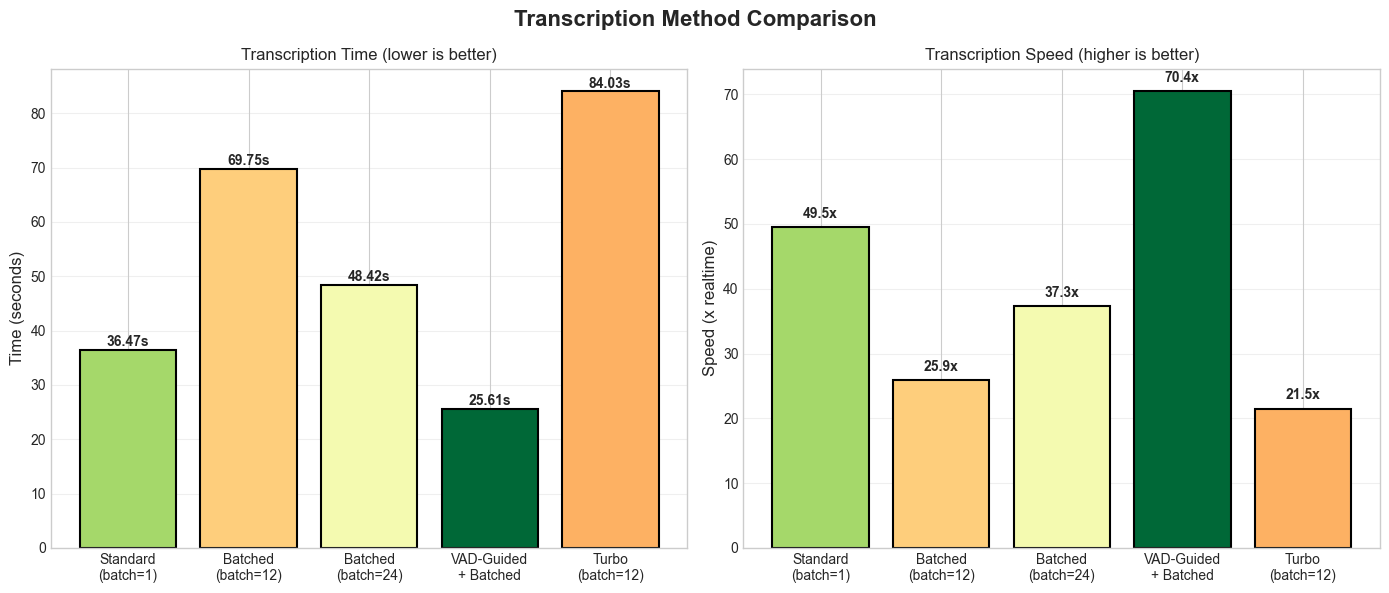


SUMMARY TABLE
Method               Time (s)     Speed (x)    vs Standard    
--------------------------------------------------------------------------------
Standard (batch=1)   36.47        49.5         1.00           x faster
Batched (batch=12)   69.75        25.9         0.52           x faster
Batched (batch=24)   48.42        37.3         0.75           x faster
VAD-Guided + Batched 25.61        70.4         1.42           x faster
Turbo (batch=12)     84.03        21.5         0.43           x faster

🏆 WINNER: VAD-Guided + Batched (70.4x realtime)


In [50]:
# Visualize comparison results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Transcription Method Comparison', fontsize=16, fontweight='bold')

methods = comparison_results['method']
times = comparison_results['time']
speeds = comparison_results['speed']

# Color gradient based on speed (faster = greener)
colors = plt.cm.RdYlGn([s / max(speeds) for s in speeds])

# 1. Transcription Time (lower is better)
ax1 = axes[0]
bars1 = ax1.bar(range(len(methods)), times, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, fontsize=10)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Transcription Time (lower is better)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars1, times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Speed (higher is better)
ax2 = axes[1]
bars2 = ax2.bar(range(len(methods)), speeds, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, fontsize=10)
ax2.set_ylabel('Speed (x realtime)', fontsize=12)
ax2.set_title('Transcription Speed (higher is better)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars2, speeds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.1f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(f"{'Method':<20} {'Time (s)':<12} {'Speed (x)':<12} {'vs Standard':<15}")
print("-" * 80)

baseline_time = comparison_results['time'][0]  # Standard method
for i, method in enumerate(methods):
    t = times[i]
    s = speeds[i]
    speedup = baseline_time / t
    method_clean = method.replace('\n', ' ')
    print(f"{method_clean:<20} {t:<12.2f} {s:<12.1f} {speedup:<15.2f}x faster")

print("=" * 80)

# Find best method
best_idx = np.argmax(speeds)
print(f"\n🏆 WINNER: {methods[best_idx].replace(chr(10), ' ')} ({speeds[best_idx]:.1f}x realtime)")

In [51]:
# Compare transcription quality (text output)
print("=" * 80)
print("TRANSCRIPTION QUALITY COMPARISON")
print("=" * 80)

print("\n1. STANDARD (batch=1) - Reference:")
print("-" * 40)
print(result_std['text'][:500])

print("\n2. BATCHED (batch=12):")
print("-" * 40)
print(result_batch['text'][:500])

print("\n3. TURBO MODEL:")
print("-" * 40)
print(result_turbo['text'][:500])

print("\n4. VAD-GUIDED (silence removed):")
print("-" * 40)
print(vad_full_text[:500] if vad_full_text else "No text captured")

# Simple text similarity check
def simple_similarity(text1, text2):
    """Calculate simple word overlap similarity"""
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    if not words1 or not words2:
        return 0
    intersection = words1 & words2
    union = words1 | words2
    return len(intersection) / len(union)

print("\n" + "=" * 80)
print("TEXT SIMILARITY vs STANDARD (Jaccard similarity)")
print("=" * 80)
ref_text = result_std['text']
print(f"Batched (batch=12):  {simple_similarity(ref_text, result_batch['text'])*100:.1f}%")
print(f"Batched (batch=24):  {simple_similarity(ref_text, result_batch24['text'])*100:.1f}%")
print(f"Turbo model:         {simple_similarity(ref_text, result_turbo['text'])*100:.1f}%")
print(f"VAD-Guided:          {simple_similarity(ref_text, vad_full_text)*100:.1f}%")
print("=" * 80)
print("\nNote: Higher similarity = more consistent with baseline transcription")
print("VAD-Guided may have lower similarity because silence removal can affect word boundaries.")

TRANSCRIPTION QUALITY COMPARISON

1. STANDARD (batch=1) - Reference:
----------------------------------------
 What if you can see what's actually working on YouTube right now before everybody else, backed by data? One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12 new shifts that are driving YouTube growth right now. This is an opinion. They actually spent $10,000 on this study and your cost is $0.00. I've got this broken down into the 12 insights based on questions. And this is one of the biggest questions that comes in all the time, right? What is the best

2. BATCHED (batch=12):
----------------------------------------
 What if you can see what's actually working on YouTube right now before everybody else, backed by data? One of the largest studies of 50,000 YouTube channels was conducted and it actually revealed 12 new shifts that are driving YouTube growth right now. This is an opinion. They actually spent $10,000 on this study and you

## Recommendations

Based on the comparison results:

| Use Case | Recommended Method | Why |
|----------|-------------------|-----|
| **Best Speed** | Turbo + batch=12-24 | Fastest model + parallelism |
| **Best Quality** | distil-large-v3 + batch=12 | Good balance of speed and accuracy |
| **Low Memory** | tiny/base + batch=24+ | Smaller models allow larger batches |
| **Long Audio with Silence** | VAD-Guided + Batched | Skip silence for podcasts, interviews |
| **Maximum Throughput** | distil-large-v3 + batch=24-48 | Push batch size to GPU limits |

### Key Takeaways:
1. **Batching is the #1 optimization** - always use batch_size > 1
2. **Model choice matters** - turbo/distil are faster than large-v3 with similar quality
3. **VAD helps for specific content** - podcasts, interviews with pauses
4. **Diminishing returns** - batch_size beyond 24 often doesn't help much